In [126]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Callable

## what does the data look like?

In [135]:
# get data
train_data = datasets.FashionMNIST(root="../data", train=True, download=True, transform=ToTensor())
test_data = datasets.FashionMNIST(root="../data", train=False, download=True, transform=ToTensor())

print(f"Number of training images: {len(train_data)}")
print(f"Number of labels: {len(train_data.classes)}")

img, label = train_data[0]
print(f"Shape of X: {img.shape} -> [color channels, img height, img width]")
print(f"Shape of y: {label} -> label for each image")

Number of training images: 60000
Number of labels: 10
Shape of X: torch.Size([1, 28, 28]) -> [color channels, img height, img width]
Shape of y: 9 -> label for each image


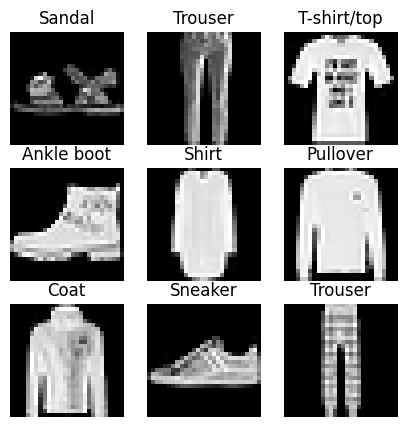

In [129]:
# {
#     "T-Shirt": 0,
#     "Trouser": 1,
#     "Pullover": 2,
#     "Dress": 3,
#     "Coat": 4,
#     "Sandal": 5,
#     "Shirt": 6,
#     "Sneaker": 7,
#     "Bag": 8,
#     "Ankle Boot": 9,
# }

figure = plt.figure(figsize=(5, 5))
cols, rows = 3, 3
get_label_name: Callable[[int], str] = lambda label: train_data.classes[label]
for i in range(1, cols * rows + 1):
    idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[idx] # type: ignore
    figure.add_subplot(rows, cols, i)
    plt.title(get_label_name(label))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## neural network

the `__init__` function describes the architecture of the neural network by defining a bunch of object variables.

the `forward` function describes how the data flows through the network by using the previously defined object variables.

_flatten_

- we flatten the 2d input image into a 1d tensor.

_linear transformation_

- $y = xW^T + b$
- we have 2 hidden layers and one output layer.
- we want to learn the weight matrix $W$ and bias vector $b$.
- fully connected layers: every neuron in the input is connected to every neuron in the output.

_relu activation function_

- $y = max(0, x)$

In [116]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=512, bias=True),
            nn.ReLU(),

            nn.Linear(in_features=512, out_features=512, bias=True),
            nn.ReLU(),

            nn.Linear(in_features=512, out_features=10, bias=True),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model = NeuralNetwork().to(device)

print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [117]:
for name, param in model.named_parameters():
    print(f"layer: {name} | size: {param.size()} | \nweights : {param[:2]} \n")

layer: linear_relu_stack.0.weight | size: torch.Size([512, 784]) | 
weights : tensor([[-0.0319,  0.0035,  0.0138,  ...,  0.0226, -0.0274, -0.0286],
        [-0.0294,  0.0324, -0.0148,  ..., -0.0308,  0.0093,  0.0304]],
       device='mps:0', grad_fn=<SliceBackward0>) 

layer: linear_relu_stack.0.bias | size: torch.Size([512]) | 
weights : tensor([-0.0137,  0.0260], device='mps:0', grad_fn=<SliceBackward0>) 

layer: linear_relu_stack.2.weight | size: torch.Size([512, 512]) | 
weights : tensor([[-0.0077,  0.0117,  0.0080,  ..., -0.0019,  0.0199, -0.0099],
        [-0.0337, -0.0306, -0.0261,  ...,  0.0237,  0.0231, -0.0337]],
       device='mps:0', grad_fn=<SliceBackward0>) 

layer: linear_relu_stack.2.bias | size: torch.Size([512]) | 
weights : tensor([-0.0229, -0.0167], device='mps:0', grad_fn=<SliceBackward0>) 

layer: linear_relu_stack.4.weight | size: torch.Size([10, 512]) | 
weights : tensor([[-0.0005, -0.0036,  0.0015,  ..., -0.0431,  0.0120, -0.0076],
        [ 0.0301,  0.0430, -0

In [136]:
# not a real image, just to test the model
X = torch.rand(1, 28, 28, device=device)

# apply softmax to the output, get highest probability class
logits = model(X)
y_pred = nn.Softmax(dim=1)(logits).argmax(1)
print(f"predicted: {y_pred} -> {get_label_name(y_pred.item())}")

predicted: tensor([8], device='mps:0') -> Bag


## train and benchmark

setting the model to `.train()` or `.eval()` mode is important because it changes the behavior of some layers like dropout and batch normalization. it's unnecessary for this model because we don't have any of those layers but it's a good habit to get into.

in the `test_loop()` we disable the gradient computation by using `torch.no_grad()` because we don't need to compute gradients during inference for tensors with `requires_grad=True`. this speeds up the computation and reduces memory.

In [140]:

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # get prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # backpropagation
        loss.backward() # compute gradients for each parameter
        optimizer.step() # update weights based on gradients
        optimizer.zero_grad() # reset gradients so they don't accumulate

        if batch % 100 == 0:
            loss = loss.item()
            current = (batch + 1) * len(X)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()

    # compute loss and accuracy over entire test set
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # average
    test_loss /= num_batches
    correct /= size

    print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


def main():
    hyperparams = {
        "batch_size": 64,
        "epochs": 5,
        "learning_rate": 1e-3,
    }
    loss_fn: nn.CrossEntropyLoss = nn.CrossEntropyLoss()
    optimizer: SGD = torch.optim.SGD(model.parameters(), lr=hyperparams["learning_rate"])

    train_batcher = DataLoader(train_data, batch_size=hyperparams["batch_size"], shuffle=True)
    test_batcher = DataLoader(test_data, batch_size=hyperparams["batch_size"], shuffle=False)
    for t in range(hyperparams["epochs"]):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_batcher, model, loss_fn, optimizer)
        test_loop(test_batcher, model, loss_fn)

main()

Epoch 1
-------------------------------
Loss: 0.735570  [   64/60000]
Loss: 0.604878  [ 6464/60000]
Loss: 0.825152  [12864/60000]
Loss: 0.622652  [19264/60000]
Loss: 0.768723  [25664/60000]
Loss: 0.720670  [32064/60000]
Loss: 0.531066  [38464/60000]
Loss: 0.523311  [44864/60000]
Loss: 0.773197  [51264/60000]
Loss: 0.827473  [57664/60000]
Accuracy: 76.2%, Avg loss: 0.672273 

Epoch 2
-------------------------------
Loss: 0.594098  [   64/60000]
Loss: 0.943268  [ 6464/60000]
Loss: 0.815638  [12864/60000]
Loss: 0.942249  [19264/60000]
Loss: 0.510381  [25664/60000]
Loss: 0.715787  [32064/60000]
Loss: 0.565259  [38464/60000]
Loss: 0.488567  [44864/60000]
Loss: 0.624243  [51264/60000]
Loss: 0.715998  [57664/60000]
Accuracy: 76.9%, Avg loss: 0.656618 

Epoch 3
-------------------------------
Loss: 0.637558  [   64/60000]
Loss: 0.508232  [ 6464/60000]
Loss: 0.638111  [12864/60000]
Loss: 0.593656  [19264/60000]
Loss: 0.710752  [25664/60000]
Loss: 0.524234  [32064/60000]
Loss: 0.542032  [38464/6